In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

#### Plotting Helper functions

In [2]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [81]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

In [4]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

#### Training Set

In [5]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Test Set

In [6]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Checking missing values in training set

In [7]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

#### Checking missing values in test set

In [8]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [9]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

#### Replace 'Name' with encoded titles

In [10]:
#Concatinate train & test data (to make sure that all unique titles are captured)
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [11]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [12]:
df_name = name_encoder(data_tot['Name'].to_frame())
df_name.head(5)

,Name,lname0,lname1,ttl
0,"Braund, Mr. Owen Harris",Braund,,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Thayer,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Peel,Mrs
4,"Allen, Mr. William Henry",Allen,,Mr


In [13]:
#Find unique titles and their counts
ttl = df_name['ttl'].unique()
ttl = pd.DataFrame([[i, len(df_name.loc[df_name['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [14]:
#Explore samples with 'Dr' title
df_name.loc[df_name['ttl']=='Dr']

,Name,lname0,lname1,ttl
245,"Minahan, Dr. William Edward",Minahan,,Dr
317,"Moraweck, Dr. Ernest",Moraweck,,Dr
398,"Pain, Dr. Alfred",Pain,,Dr
632,"Stahelin-Maeglin, Dr. Max",Stahelin-Maeglin,,Dr
660,"Frauenthal, Dr. Henry William",Frauenthal,,Dr
766,"Brewe, Dr. Arthur Jackson",Brewe,,Dr
796,"Leader, Dr. Alice (Farnham)",Leader,Farnham,Dr
1184,"Dodge, Dr. Washington",Dodge,,Dr


_**Leader, Dr. Alice (Farnham) is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [15]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

#### Explore missing values for 'Embarked'

In [16]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Display samples with similar ticket number

In [17]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class to both missed values.

In [18]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [19]:
#Encoding 'Embarked'
def embarked_encoder(data):
#     data = data.copy()
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section I will do two things:

~~1. Group all passengers by ticked ID and add a column of the gropus IDs.~~

2. For all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

~~3. Transform fare into categorical variable.~~

In [20]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

# This function will clean ticket ID from all punctuation and spaces
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [21]:
df_fam = ticket_encoder(data_tot)

Numbers of unique and non-unique tickets:

In [22]:
print('Unique tickets: %d' % len(df_fam['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(df_fam.index) - len(df_fam['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [23]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [24]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [25]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [26]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [27]:
# Encode family groups
def family_groups_encoder(data, fam_grps):
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

Functions for sex encoding and to add a family size variable:

In [28]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

# Add 'Family size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

#Encoding 'Pclass'
def pclass_encoder(data):
#     data = data.copy()
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

# Combine categorical features
def combine_features(data, feature1, feature2, name):
    lst1 = list(data[feature1].unique())
    lst2 = list(data[feature2].unique())
    d1 = len(lst1)
    d2 = len(lst2)
    mask = np.array(range(d1 * d2)).reshape(d1,d2)
    data = data.copy()
    df = []
    for i in data.index:
        df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
    df = pd.DataFrame(df, columns=[name])
    return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

# Transform 'Fare' to account for number of non-unique samples
def fare_transformer(data):
    data['Fare'] = data['Fare'].apply(lambda i: np.log(i+1) * len(data.loc[data['Fare']==i].index))
    return data

#### Define age intervals using clastering



In [29]:
#Transform 'Age'
df_age = data_tot['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [30]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict class labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [31]:
# Add age class labels to the data set
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

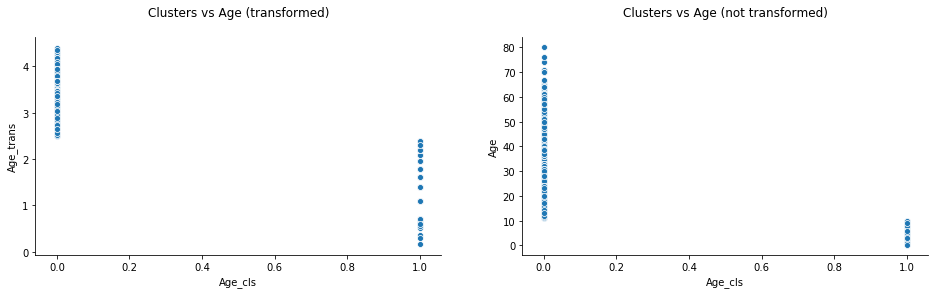

In [32]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

#### Distributions within clasters (age - transformed)

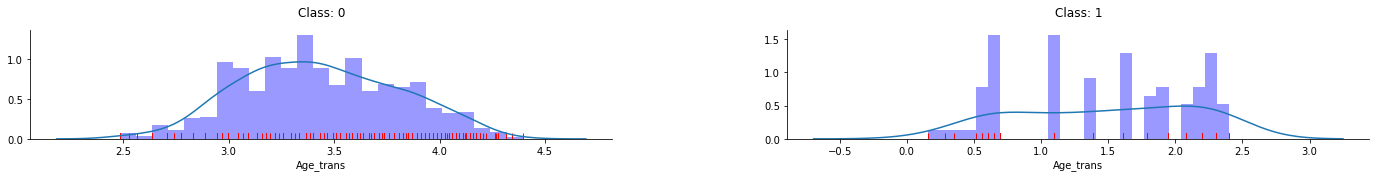

In [33]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

#### Distributions within clasters (age - not transformed)

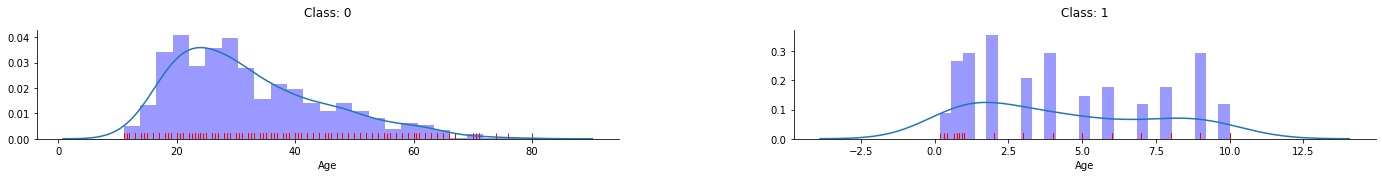

In [34]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [35]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

### Predict missing missing values for age

In [36]:
data = family_groups_encoder(data_tot, fam_grps)
data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_transformer(data)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

data = data[data['Age'].notna()].copy()
data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize']]

data = age_transformer(data, age_clast_model)

#### Plot correlation matrix:

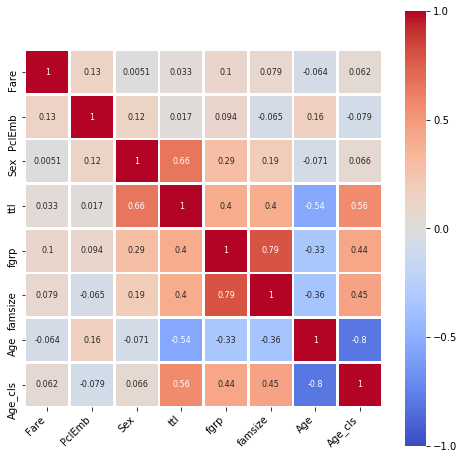

In [37]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train model for age class prediction

In [38]:
# train test split
X = data.drop(columns=['Age', 'Age_cls', 'Sex', 'famsize'])
y = data['Age_cls']

In [39]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [40]:
params = {'learning_rate': 0.06796610169491525, 
          'n_estimators': 85,
          'min_weight_fraction_leaf': 0.039230769230769236, 
          'min_impurity_decrease': 0.001642857142857143,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
age_cls_model.fit(X,y)
cv_rep(age_cls_model, X, y, cv, scoring)

# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 40), 'n_estimators': np.arange(5, 100, 20)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.01, 15)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001,0.001, 15)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.973045,0.993478,0.902251
std_train,0.017294,0.001860,0.019091
mean_test,0.964754,0.990692,0.891418
std_test,0.029401,0.003155,0.021377


#### Train model for age prediction

In [41]:
# train test split
X = data.drop(columns=['Age', 'Sex', 'famsize'])
y = data['Age']

In [42]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

In [43]:
params = {'learning_rate': 0.15615384615384617, 
          'n_estimators': 25,
          'min_weight_fraction_leaf': 0.04413793103448276, 
          'min_impurity_decrease': 0.13692307692307693,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.0002}

age_reg_mogel = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
age_reg_mogel.fit(X,y)
cv_rep(age_reg_mogel, X, y, cv, scoring)

# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 40), 'n_estimators': np.arange(5, 100, 20)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.1, 30), 'min_impurity_decrease': np.linspace(0.1, 0.5, 20)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.1, 30)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.001, 100)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

,explained_variance,r2
mean_train,0.726407,0.726407
std_train,0.011037,0.011037
mean_test,0.702536,0.700838
std_test,0.058686,0.059276


In [44]:
#Age encoder (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_mogel):
    cols = ['Fare', 'PclEmb', 'ttl', 'fgrp']
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]

    # transform non-null age values
    age_trans = data_notna['Age'].apply(lambda i: np.log(i+1)).to_frame()
    data_notna = pd.concat([data_notna.drop(columns=['Age']), age_trans], axis=1)

    # predict class labels
    X = data_na[cols].reset_index(drop=True)
    age_cls = pd.Series(age_cls_model.predict(X), name='Age_cls').to_frame()

    # predict age
    X_age_cls = pd.concat([X, age_cls], axis=1)
    age_preds = pd.Series(age_reg_mogel.predict(X_age_cls), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index(drop=True).drop(columns=['Age']), age_preds], axis=1)
    return pd.concat([data_na, data_notna])

In [45]:
# Transform 'Age to account for non-unique samples'
def age_transformer_counts(data):
    data['Age'] = data['Age'].apply(lambda i: np.log(i * len(data.loc[data['Age']==i].index)))
    return data

## Predict survivals

#### Preprocessind data

In [46]:
data = family_groups_encoder(data_train, fam_grps)
data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_transformer(data)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

data = data[['PassengerId', 'Survived', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]

data = age_predictor(data, age_cls_model, age_reg_mogel)
data = age_transformer_counts(data)

#### Train base estimators for stacking model

In [47]:
X = data.drop(columns=['Survived', 'fgrp', 'PassengerId'])
y = data['Survived']

In [48]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [49]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [50]:
base_scores = {}

In [51]:
gpc = gaup.GaussianProcessClassifier(max_iter_predict=11, random_state=random_state)
scores = cv_rep(gpc, X, y, cv, scoring)
base_scores['gpc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'max_iter_predict': np.arange(1000, 2000, 10)}
# gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.879491  0.935512         0.901832
std_train            0.012180  0.007545         0.010421
mean_test            0.766393  0.837290         0.791093
std_test             0.034097  0.025314         0.037399


In [52]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_components': np.arange(1,5)}
# lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.777912  0.828908         0.800522
std_train            0.012107  0.010136         0.012060
mean_test            0.759170  0.817096         0.787067
std_test             0.022861  0.016268         0.015537


In [53]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.02)
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'reg_param': np.linspace(0.01,1,12)}
# qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.793340  0.835909         0.821297
std_train            0.014022  0.011829         0.014374
mean_test            0.777973  0.818909         0.807461
std_test             0.021589  0.022150         0.024123


In [54]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.056846153846153845,
                             n_estimators=85,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.1, 40)}
# abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.820188  0.870884         0.833588
std_train            0.011855  0.012776         0.012336
mean_test            0.803645  0.855405         0.820477
std_test             0.021202  0.024367         0.020818


In [55]:
gbc = ens.GradientBoostingClassifier(loss='exponential', 
                                     criterion='friedman_mse', 
                                     learning_rate=0.15084745762711865,
                                     n_estimators=65,
                                     min_impurity_decrease=0.0093076923,
                                     min_weight_fraction_leaf=0.011205128205128204,
                                     max_depth=3,
                                     subsample=1,
                                     ccp_alpha=0.016813,
                                     random_state=random_state)
scores = cv_rep(gbc, X, y, cv, scoring)
base_scores['gbc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 60), 'n_estimators': np.arange(5, 100, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.1, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001,0.001, 15)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816107  0.874554         0.840727
std_train            0.017877  0.018500         0.009764
mean_test            0.794110  0.858167         0.822362
std_test             0.023581  0.019868         0.025449


In [56]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               n_estimators=25,
                               max_depth=4,
                               ccp_alpha=0.0)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(3, 10)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821366  0.884262         0.847881
std_train            0.018147  0.011342         0.013172
mean_test            0.793019  0.856155         0.819828
std_test             0.027175  0.021548         0.026980


In [57]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=45,
                                 max_depth=5,
                                 ccp_alpha=0.0112637)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(5, 10)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001, 0.01, 15)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.827456  0.920102         0.854664
std_train            0.010376  0.010735         0.006048
mean_test            0.794593  0.870065         0.824682
std_test             0.023028  0.025195         0.027325


In [58]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3122448979591839)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.1, 10, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.754829  0.827809         0.750550
std_train            0.015108  0.010279         0.014930
mean_test            0.742174  0.816684         0.742633
std_test             0.020096  0.016797         0.019431


In [59]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                                     C=0.21020408163265308)
scores = cv_rep(pac, X, y, cv, scoring)
base_scores['pac'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.1, 1, 99)}
# pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.670768  0.726982         0.715466
std_train            0.047874  0.054953         0.052145
mean_test            0.671759  0.733042         0.713997
std_test             0.058210  0.070623         0.058536


In [60]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.122448979591837)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'alpha': np.linspace(10, 20, 99)}
# rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.755963  0.830063         0.755125
std_train            0.017954  0.010336         0.018734
mean_test            0.742892  0.818173         0.748528
std_test             0.022750  0.017097         0.026322


In [61]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=9428.57142857143)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(9000, 12000, 99)}
# svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.836088  0.890263         0.840888
std_train            0.016953  0.015669         0.016856
mean_test            0.794860  0.862986         0.805650
std_test             0.029573  0.026758         0.031079


In [62]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.5102089795918366)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'nu': np.linspace(0.00001,1,99)}
# nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.788525  0.848877         0.817025
std_train            0.009610  0.011796         0.008885
mean_test            0.774207  0.820474         0.807873
std_test             0.026405  0.027233         0.026722


In [63]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,abc,svc,rfc,gbc,etc,qda,nusvc,gpc,lda,rc,lr,pac
test_score,0.803645,0.794860,0.794593,0.794110,0.793019,0.777973,0.774207,0.766393,0.759170,0.742892,0.742174,0.671759
train_score,0.820188,0.836088,0.827456,0.816107,0.821366,0.793340,0.788525,0.879491,0.777912,0.755963,0.754829,0.670768


In [64]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [65]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

c:\00_data\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


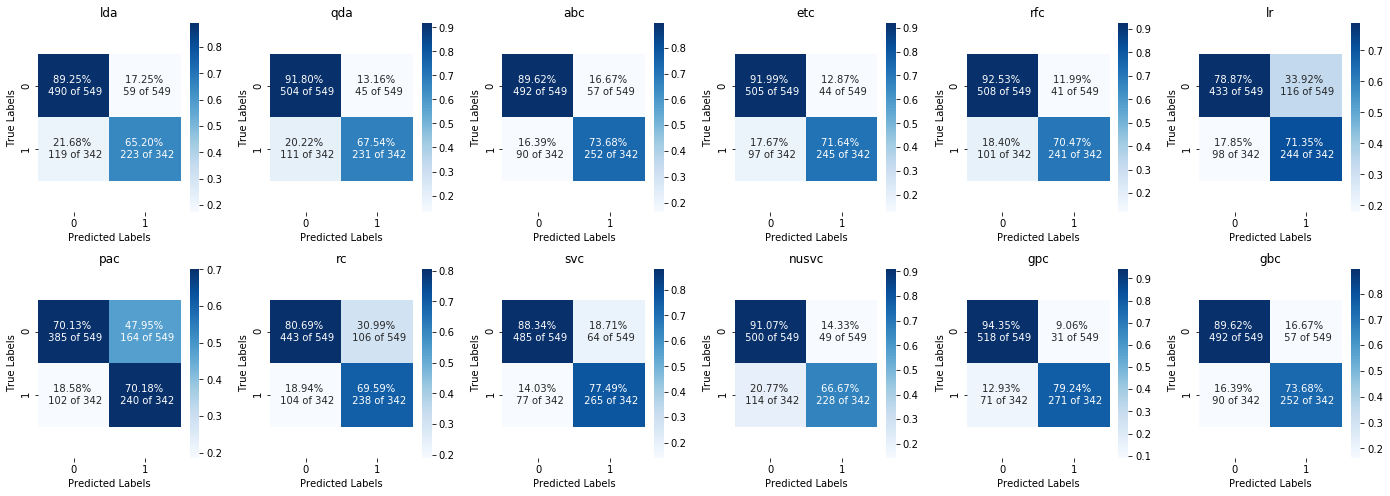

In [66]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [67]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [68]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

#### Base estimators correlation matrix

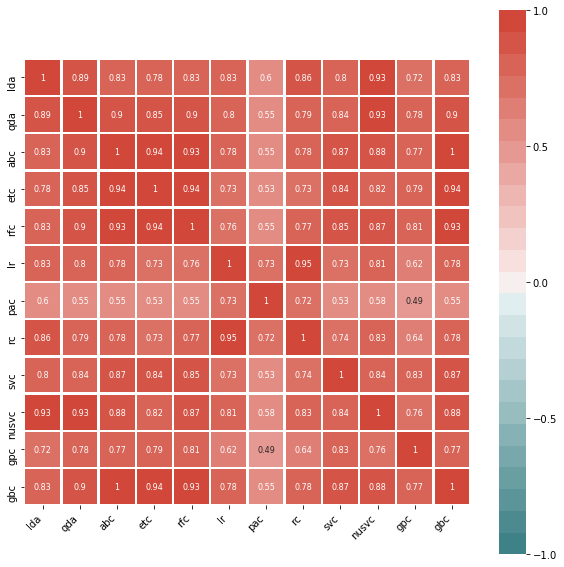

In [69]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [70]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,abc,gbc,rfc,qda,nusvc,etc,lda,svc,rc,lr,gpc,pac
cc,0.770508,0.770508,0.761014,0.760187,0.759443,0.741762,0.740974,0.728022,0.715725,0.710195,0.662366,0.530778


#### Select less correlated models

In [71]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'lr':lr,'pac':pac,'svc':svc}

In [72]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

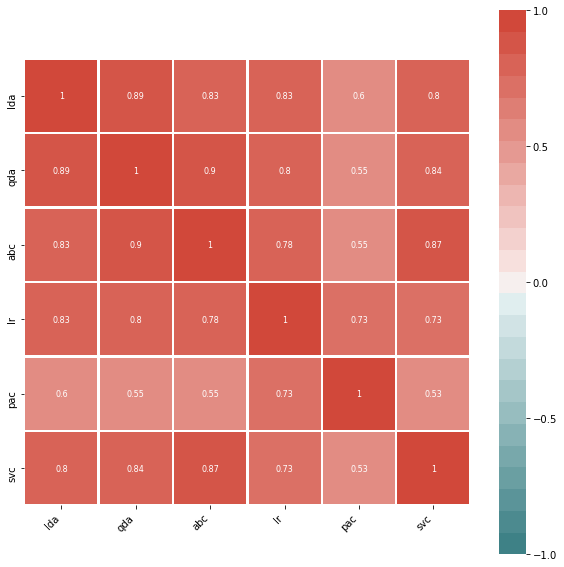

In [73]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

#### Compare stacking classifier score for different final estimator models

In [74]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [75]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('gbc', ens.GradientBoostingClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [76]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [77]:
scores

,lr,svc,abc,rfc,gbc,etc
Test_score,0.796967,0.795696,0.795455,0.791386,0.791083,0.789017
Train_score,0.821152,0.819841,0.824846,0.820109,0.819557,0.816719


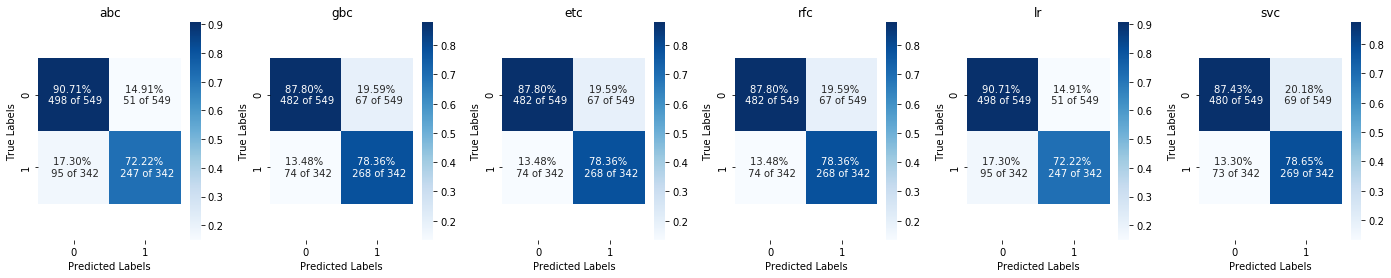

In [78]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

#### Train stacking model

In [79]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(algorithm='SAMME.R', 
                                                                         learning_rate=0.1,
                                                                         n_estimators=25,
                                                                         random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

# param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20), 'final_estimator__learning_rate': np.linspace(0.001, 1, 40)}
# model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.821064,0.852050,0.836468
std_train,0.011899,0.019283,0.011571
mean_test,0.799821,0.816190,0.819587
std_test,0.022534,0.025011,0.021100


In [84]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 120, 50), 'final_estimator__learning_rate': np.linspace(0.001, 0.5, 70)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.820368  0.854856         0.836714
std_train            0.012121  0.018682         0.011009
mean_test            0.802127  0.819226         0.820980
std_test             0.023177  0.028700         0.020195
{'final_estimator__learning_rate': 0.008231884057971015, 'final_estimator__n_estimators': 105}


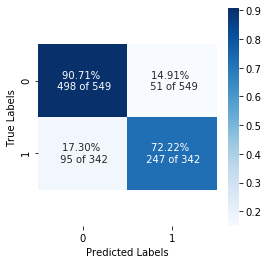

In [83]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [81]:
model_st_cal = calib.CalibratedClassifierCV(base_estimator=model_st, method='sigmoid', cv=cv)
model_st_cal.fit(X,y)

CalibratedClassifierCV(base_estimator=StackingClassifier(cv=5,
                                                         estimators=[('lda',
                                                                      LinearDiscriminantAnalysis(n_components=None,
                                                                                                 priors=None,
                                                                                                 shrinkage='auto',
                                                                                                 solver='lsqr',
                                                                                                 store_covariance=False,
                                                                                                 tol=0.0001)),
                                                                     ('qda',
                                                                      QuadraticDiscriminantAnalysi

## Predict test set

#### Preprocessind data

In [82]:
data = family_groups_encoder(data_test, fam_grps)
data = fare_encoder(data, [sig1, fam1, famch1])
data = fare_transformer(data)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)
data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')

data = data[['PassengerId', 'Fare', 'Age', 'ttl', 'famsize', 'PclEmb', 'fgrp']]

data = age_predictor(data, age_cls_model, age_reg_mogel)
data = age_transformer_counts(data)

#### Make predictions

In [83]:
X = data.drop(columns=['fgrp', 'PassengerId'])

In [84]:
y_preds = model_st.predict(X)
y_preds_p = model_st.predict_proba(X)
y_preds_pp = model_st_cal.predict_proba(X)

In [85]:
df = pd.DataFrame(y_preds_p)

In [86]:
df1 = pd.DataFrame(y_preds)

In [87]:
df2 = pd.DataFrame(y_preds_pp)

In [88]:
df.max()

0    0.538362
1    0.535975
dtype: float64

In [89]:
df2.max()

0    0.889653
1    0.824584
dtype: float64

In [90]:
len(df2.loc[df2[1]>0.8257216, 1].index)

0

In [91]:
df1.loc[df1[0]==1]

,0
1,1
3,1
4,1
10,1
15,1
...,...
407,1
413,1
414,1
415,1
